In [1]:
!pip install qiskit[visualization] qiskit-ibm-runtime qiskit-aer qiskit_qasm3_import

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter, ParameterVector
import qiskit.qasm3
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import IfElseOp, Instruction

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.0 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=c76d03cfe154255854b83c90170a2804ab27d8e2f546d7e8e8e1f3fce536078b
  Stored in di

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

### Alice and Bob randomly generate different basis and the keys are being sent to BOB by alice but intercepted by Eve


QC Function

In [3]:
def transmission_with_interception(A_RNG_KEY,A_RNG_BASE,B_RNG_BASE,Eve_RNG_Base):
  qc=QuantumCircuit(2,2)
  if(A_RNG_KEY==1):
    qc.x(0)
  if(A_RNG_BASE==1):
    qc.h(0)
  if Eve_RNG_Base==1:
    qc.h(0)
  p=qc.measure(0,0)

  if p==1:
    qc.x(1)
  if Eve_RNG_Base==1:
    qc.h(1)
  if(B_RNG_BASE==1):
    qc.h(1)
  qc.measure(1,1)
  return qc

In [4]:
#Parameters
n =512
noise_prob = 0.1 #10%noise

#Random bits and bases
a_bit = [np.random.randint(0, 2) for _ in range(n)]
a_base = [np.random.randint(0, 2) for _ in range(n)]
b_base = [np.random.randint(0, 2) for _ in range(n)]
e_base=[np.random.randint(0,2) for i in range(n)]

noise_model = NoiseModel()

# Gate noise (depolarizing)
dep_error = depolarizing_error(noise_prob, 1)
noise_model.add_all_qubit_quantum_error(dep_error, ['x', 'h'])

# Measurement noise (bit flip)
meas_error = pauli_error([('X', noise_prob), ('I', 1 - noise_prob)])
noise_model.add_all_qubit_quantum_error(meas_error, ['measure'])

# Build noisy simulator
sim_backend = AerSimulator(noise_model=noise_model)
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
sampler = Sampler(mode=sim_backend)

#Run simulation
b_bits = {}
a_bits = {}

for i in range(n):
    isa_qc = pm.run(transmission_with_interception(a_bit[i], a_base[i], b_base[i],e_base[i]))
    job = sampler.run([isa_qc], shots=1)
    result = job.result()
    counts = result[0].data.c.get_counts()
    first_key = list(counts.keys())[0]
    b_bits[i] = int(first_key)//10 #11//10=1
    a_bits[i] = a_bit[i]

#Measure raw disagreement
diff_count = sum(1 for i in a_bits if a_bits[i] != b_bits[i])
print("No of mismatched bits (before basis filtering):", diff_count )

No of mismatched bits (before basis filtering): 256


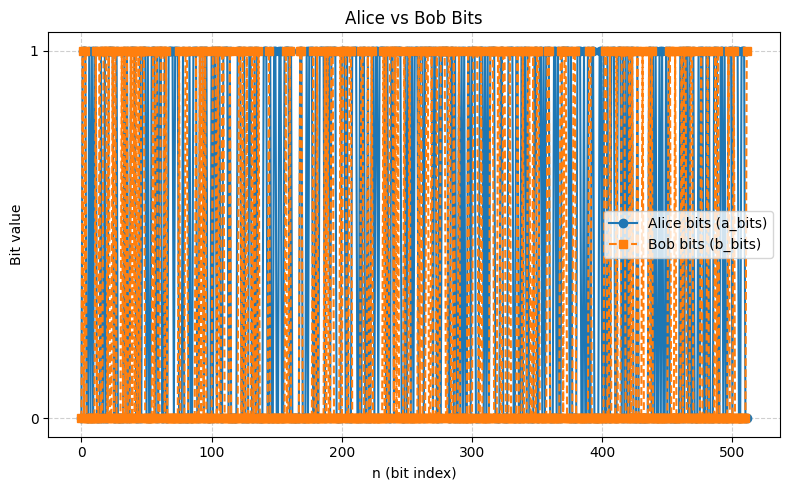

In [5]:

# Extract x (indices) and y (bit values)
x = list(a_bits.keys())
a_y = list(a_bits.values())
b_y = list(b_bits.values())

plt.figure(figsize=(8, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()


In [6]:
# Filter only where bases are equal
filtered_a_bits = {}
filtered_b_bits = {}
matching_indices=[]

for i in range(len(a_base)):
    if a_base[i] == b_base[i]:
        matching_indices.append(i)
        filtered_a_bits[i] = a_bits[i]
        filtered_b_bits[i] = b_bits[i]


a_bits = filtered_a_bits
b_bits = filtered_b_bits

print("Filtered a_bits:", a_bits)
print("Filtered b_bits:", b_bits)
print("Number of matching bases:", len(a_bits))


Filtered a_bits: {0: 0, 1: 1, 3: 1, 4: 0, 10: 1, 11: 1, 16: 0, 17: 0, 18: 1, 19: 0, 28: 0, 30: 0, 33: 1, 34: 0, 36: 0, 37: 0, 38: 1, 40: 1, 44: 0, 45: 1, 47: 1, 58: 1, 59: 0, 60: 1, 62: 0, 65: 0, 66: 0, 67: 1, 68: 1, 70: 1, 71: 0, 74: 1, 77: 0, 80: 0, 81: 0, 82: 0, 84: 0, 87: 1, 91: 1, 92: 1, 93: 1, 97: 0, 99: 0, 100: 1, 102: 1, 104: 0, 105: 1, 106: 1, 108: 0, 110: 1, 111: 1, 112: 1, 114: 1, 115: 0, 116: 0, 117: 0, 118: 0, 121: 1, 122: 1, 123: 0, 124: 0, 129: 1, 130: 1, 131: 0, 135: 1, 136: 0, 137: 0, 139: 0, 141: 1, 142: 1, 145: 1, 146: 0, 147: 0, 148: 1, 151: 0, 157: 1, 158: 1, 159: 1, 161: 1, 164: 0, 165: 0, 166: 0, 167: 0, 168: 1, 172: 0, 174: 0, 175: 1, 177: 1, 179: 0, 180: 1, 182: 0, 184: 1, 185: 1, 186: 1, 187: 0, 188: 1, 189: 1, 190: 1, 192: 1, 195: 1, 197: 0, 201: 1, 205: 0, 206: 0, 212: 0, 214: 1, 216: 1, 217: 1, 218: 0, 222: 0, 223: 1, 227: 1, 228: 0, 231: 1, 232: 1, 237: 0, 238: 1, 239: 1, 241: 1, 242: 1, 243: 1, 245: 1, 246: 0, 247: 0, 248: 0, 249: 1, 250: 0, 256: 1, 258: 

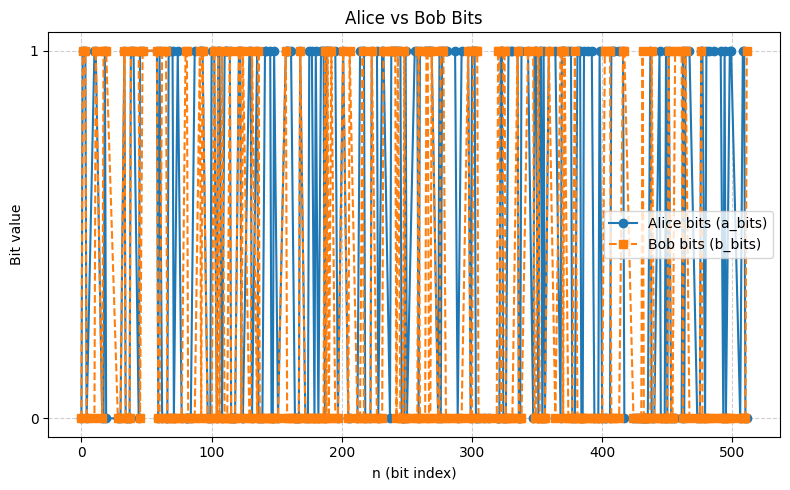

In [7]:
# Extract x (indices) and y (bit values)
x = list(a_bits.keys())
a_y = list(a_bits.values())
b_y = list(b_bits.values())

plt.figure(figsize=(8, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

Actual QBER = 0.5039
Actual bits with errors= 130
Average estimated QBER = 0.5024 ± 0.0321 (std over 200 runs)


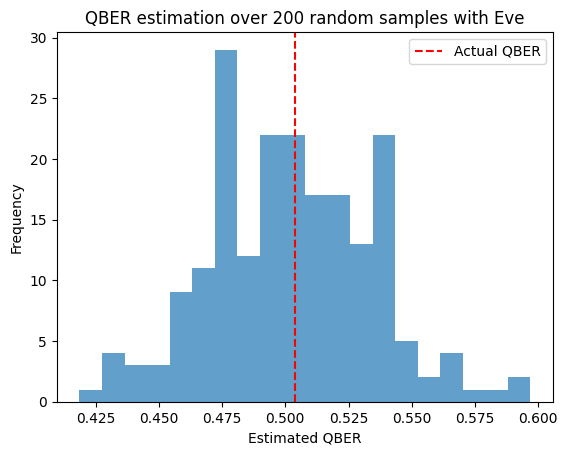

In [8]:
#alice anounces subset no of bits to BOB

subset = 0.5  # 50% of matching bits used for estimation
sample_size = int(subset * len(matching_indices))

actual_qber = sum(a_bits[i] != b_bits[i] for i in matching_indices) / len(matching_indices)
print(f"Actual QBER = {actual_qber:.4f}")
print("Actual bits with errors=",sum(a_bits[i] != b_bits[i] for i in matching_indices))

# Run multiple trials of random sampling to see variability
num_trials = 200
estimates = []

for _ in range(num_trials):
    sample_indices = random.sample(matching_indices, sample_size)
    qber_estimate = sum(a_bits[i] != b_bits[i] for i in sample_indices) / sample_size
    estimates.append(qber_estimate)

mean_estimate = np.mean(estimates)
std_estimate = np.std(estimates)

print(f"Average estimated QBER = {mean_estimate:.4f} ± {std_estimate:.4f} (std over {num_trials} runs)")

plt.hist(estimates, bins=20, alpha=0.7)
plt.axvline(actual_qber, color='red', linestyle='--', label='Actual QBER')
plt.title(f"QBER estimation over {num_trials} random samples with Eve")
plt.xlabel("Estimated QBER")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# **QBER INCREASES SIGNIFICANTLY SUGGESTING EVE'S PRESENCE**